## House Prices
### Kaggle Competition

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home

#### Notebook Preparation

In [1]:
# Styling
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:70% !important; }</style>"))

# Data import
import pandas as pd
import numpy as np
import warnings

# Jupyter notebook settings
%load_ext autotime
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)

time: 330 µs


In [2]:
houses = pd.read_csv('Data/train.csv',index_col=0)
test_houses = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sample_submission.csv')

time: 42.3 ms


We can see that PoolQC MiscFeature Alley Fence have at least over 80% of missing data
These are categorical columns, after some analysis we can see that they are categorised this way:
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
       
##### Categorical values       
Categorize them with values (ints) and -1 if Nan
Apply this idea to all the columns and once that's done, take care of the missing values in the non categorical variables

##### Non Categorical values
We Identified non categorical variables that have Nan values: GarageYrBlt and LotFrontAge
After looking at their descriptions, nan GarageYrBlt occurs when the property doesn't have a garage and LotFrontAge when it doesn't have an Alley, It's then safe to replace nan values by -1

In [3]:
def categorize(serie):
    return serie.astype('category').cat.codes

time: 401 µs


In [4]:
# Categorizing the categorical values into integers.
houses[list(houses.select_dtypes(include='object').columns)] = houses.select_dtypes(include='object').apply(categorize,axis=1)

time: 662 ms


In [5]:
# Replacing Years garage built with -1 if the property doesn't have a garage

#houses['GarageYrBlt'] = houses['GarageYrBlt'].replace(np.nan, -1)
#houses['LotFrontage'] = houses['LotFrontage'].replace(np.nan, -1)
houses = houses.replace(np.nan, -1)

time: 1.32 ms


In [6]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df,n):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


time: 4.75 ms


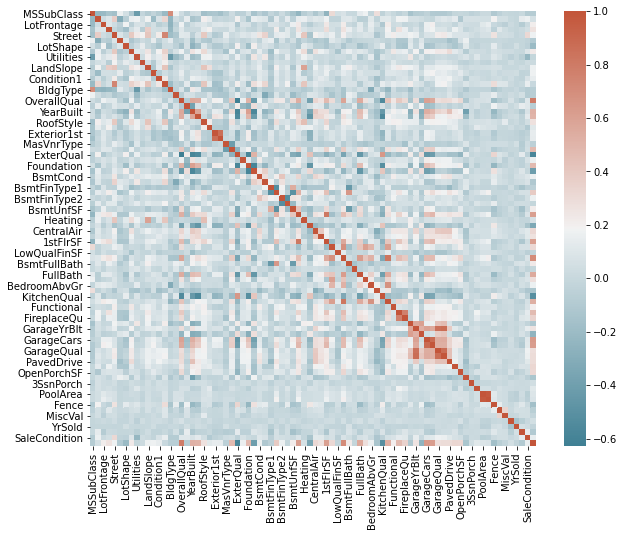

time: 1.22 s


In [7]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = houses.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=(sns.diverging_palette(220, 20, as_cmap=True)),
            square=False, ax=ax);

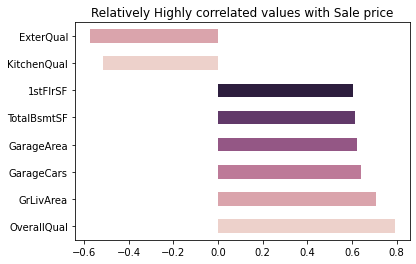

time: 144 ms


In [8]:
spc = corr.iloc[-1].sort_values(ascending=False)
selected_spc = spc[(spc <= -0.5) | (spc >= 0.6)].drop('SalePrice')

selected_spc.plot(kind='barh',
                  title='Relatively Highly correlated values with Sale price',
                  color=list(sns.cubehelix_palette(as_cmap=False)));

After The first part of preprocessing let's try building a simple model

In [9]:
from sklearn.model_selection import train_test_split

X,y = houses.drop('SalePrice',axis=1),houses['SalePrice']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=18)

time: 89.4 ms


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error as msle
from math import sqrt

lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

print('RMSE Linear regressor:', round(sqrt(msle(y_test,y_pred)),3))

RMSE Linear regressor: 0.157
time: 37 ms
